In [61]:
import os

import torch
import torch.nn as nn
from torch import optim
import tensorflow as tf
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import torch
from torchvision import transforms
from torchvision import datasets
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score,f1_score
import csv

In [62]:
# function below is a manual implementation of a one hot encoding
def onehot_encoding(x, column_name=None):
    classes_set = sorted(list(set(x)))
    classes_dict = dict()
    classes = 0
    for i in classes_set:
        if i not in classes_dict.keys():
            classes_dict[i] = classes
            classes += 1
    one_hot = np.zeros(shape=(len(x), classes))
    for i in range(len(x)):
        one_hot[i][classes_dict[x[i]]] = 1
    one_hot_column_names = np.array(one_hot.astype('float'))
    # encoded categorical features
    return one_hot_column_names
# image normalization
def normalize_images(imgs):
    return imgs/255.

In [63]:
class Dataset:
    def __init__(self,train_or_test):
        data=datasets.MNIST(root='mnist', download=True,train=train_or_test)
        self.x,self.y=data.data,np.array(data.targets)
        self.x=normalize_images(self.x)
        # self.y=onehot_encoding(self.y)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, item):
        return self.x[item],self.y[item]

In [ ]:
# Create a PYTORCH dataset with one-hot encoding + normalization
# (Dataset's labels are already provedided in the appropriate form.)

In [64]:
# loading dataset
train=Dataset(train_or_test=True)
test=Dataset(train_or_test=False)
# answers
test.y

100%|██████████| 9912422/9912422 [00:00<00:00, 43826370.68it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 12338123.23it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41819196.24it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9421626.49it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw


array([7, 2, 1, ..., 4, 5, 6])

In [65]:
# take a view on our dataset
def show_dataset(dataset_,dataset_labels_):
    # to show labels in convenient format
    figure = plt.figure(figsize=(6, 6))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = tf.random.uniform(shape=(1,), minval=0, maxval=len(dataset_), dtype=tf.int64).numpy()[0]
        # retrieve image name and it's labels
        img, label = dataset_[sample_idx],dataset_labels_[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

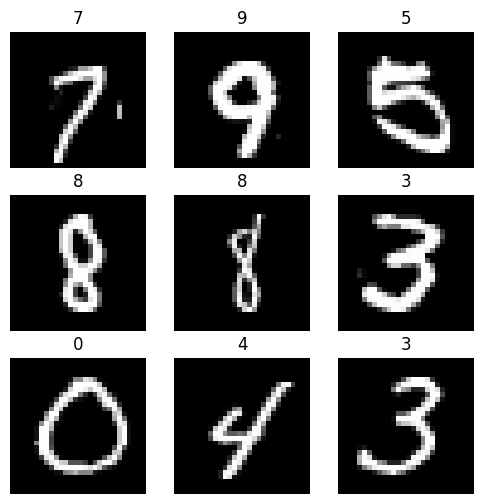

In [66]:
# take a view on dataset
show_dataset(train.x,train.y)

In [67]:
# batch_size=64
train_loader,test_loader=DataLoader(train,shuffle=True),DataLoader(test,shuffle=True)

In [68]:
loss_type=nn.CrossEntropyLoss()

In [ ]:
# We have confusion matrix, where it is easy to identify true_positives, false_positives, true negatives.
# True Positives_A: The number of samples correctly classified as class A.
# False Positives_A: The number of samples that are not of class A but are incorrectly classified as class A.(numbers in rows)
# False Negatives_A: The number of samples of class A that are incorrectly classified as not being of class A.(numbers in columns)
# 
# True_positives              False_positives
# 
# False negatives             True negatives

In [69]:
def compute_precision_recall(matrix_):
    y_true,y_pred=[i[0] for i in matrix_],[i[1] for i in matrix_]
    # average = 'macro' => matrics are calculated across all classes for entire classification task
    precision=precision_score(y_true=y_true,y_pred=y_pred,average='macro')
    recall=recall_score(y_true=y_true,y_pred=y_pred,average='macro')
    f1_score_=f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    return precision,recall,f1_score_

In [70]:
# drawing Confusion matrix for statistical analysis
def final_matrix(matrix,experiment,leng):
    my_matrix=torch.zeros(leng,leng,dtype=torch.int32).tolist()
    # fill the confusion matrix with values
    for i in matrix:
        my_matrix[i[0]][i[1]]+=1
    my_matrix=np.array(my_matrix)
    my_matrix=(my_matrix.T/my_matrix.sum(axis=1)).T
    my_matrix=np.round(my_matrix, 3)
    plt.figure(figsize=(30,36))
    # display matrix in blue colors
    disp = ConfusionMatrixDisplay(confusion_matrix=my_matrix, display_labels=range(10))
    disp.plot(cmap='Blues')
    # save to a folder
    plt.savefig(f'./Model_scores{experiment}/Confusion_matrix.jpg')
    plt.close()

In [71]:
def draw_plots(experiment,train_accuracy, test_accuracy, train_loss_, test_loss_):
    # To draw plots of accuracy and loss of train and test datasets
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='blue', linestyle='--',
             label='train accuracy')
    plt.plot(test_accuracy, color='red', linestyle='--',
             label='test accuracy')
    plt.ylabel = 'Accuracy'
    plt.xlabel = 'Epochs' 
    plt.legend()
    plt.savefig(f'./Model_scores{experiment}/accuracy.jpg')
    plt.close() 
    # Loss plot
    plt.figure(figsize=(10, 7))
    plt.plot(np.array(train_loss_), color='blue', linestyle='--',
             label='train loss')
    plt.plot(np.array(test_loss_), color='red', linestyle='--',
             label='test loss')
    plt.ylabel = 'Loss'     
    plt.xlabel = 'Epochs'   
    plt.legend()
    plt.savefig(f'./Model_scores{experiment}/loss.jpg')
    plt.close()    

In [72]:
def training_process(loader,my_model,optimize,loss,batch_size=1,):
    # turn on the training mode
    my_model.train()
    running_correct,epoch_loss=0,0
    epoch_accuracy=0
    for i, (images,labels) in tqdm(enumerate(loader), total=len(loader)):
            # gradients are reset to zero 
            optimize.zero_grad()
            outputs=my_model(images.view(-1,784))
            _,predictions=torch.max(outputs.data,1)
            loss_val=loss(outputs,labels)
            # backward pass 
            loss_val.backward()
            optimize.step()
            epoch_loss=loss_val/len(loader)
            running_correct+=(labels==predictions).sum().item()
            epoch_accuracy=100.*(running_correct/len(loader))
    return epoch_loss,round(epoch_accuracy/batch_size,6)

In [73]:
def evaluating_perfomance(loader_test,my_model,loss,last_epoch=False):
        with torch.no_grad():
            # variables to draw confusion matrix
            Confusion_list=[]
            running_correct,epoch_loss=0,0
            total=0
        #no updating loss
            for images,labels in loader_test:
                # flatten image to use it in the model
                outputs=my_model(images.view(-1,784))
                # compute loss on test dataset
                loss_val=loss(outputs,labels)
                # compute the loss and divide by the size of test dataset (10000)
                epoch_loss=loss_val/len(loader_test)
                for index,i in enumerate(outputs):
                    # torch.argmax(i) -> from the array of predictions extract the biggest one 
                    if torch.argmax(i)==labels[index]:
                        running_correct+=1
                    total+=1
                _,predicted_labels=torch.max(outputs.data,1)
                # after last epoch prepare data for Confusion matrix and graphs
                if last_epoch:
                    predicted_data=list(zip(labels.tolist(),predicted_labels.tolist()))
                    Confusion_list.extend(predicted_data)
            # if it is the last epoch --> return the list for confusion matrix
            if not last_epoch:
                return epoch_loss,100.*round(running_correct/total,6),[]
            else:
                return epoch_loss,100.*round(running_correct/total,6),Confusion_list

In [74]:
def make_directory(experiment):
    if f'Model_scores{experiment}' not in os.listdir('./'):
        os.mkdir(f"./Model_scores{experiment}")

In [75]:
def run_epochs(learning_rate=0.001,epochs=10,experiment_number=None,model_type=None,batch_size=1):
    optimizer=optim.SGD(model_type.parameters(),lr=learning_rate)
    criterion=nn.CrossEntropyLoss()
    train_loss,testing_loss=[],[]
    train_acc,testing_acc=[],[]
    last_epoch=False
    for epoch in range(1,epochs+1):
            if epoch==epochs:
                last_epoch=True
            print(f"Epoch number: {epoch}")
            print()
            print('Training..')
            loss_,accuracy=training_process(loader=train_loader,my_model=model_type,optimize=optimizer,loss=criterion,batch_size=batch_size)
            train_loss.append(loss_)
            train_acc.append(accuracy)
            print(f'Training_Loss: {loss_} and Training_Accuracy: {accuracy} %')
            print('Testing..')
            loss_test,accuracy_test,confusion__matrix=evaluating_perfomance(loader_test=test_loader,my_model=model_type,loss=criterion,last_epoch=last_epoch)
            testing_loss.append(loss_test)
            testing_acc.append(accuracy_test)
            print(f'Testing_Loss: {loss_test} and Testing_Accuracy: {accuracy_test} %')
            print()
            print('-'*80)
            print()
    make_directory(experiment_number)
    final_matrix(confusion__matrix,experiment_number,leng=10)
    train_loss,testing_loss=[float(i) for i in train_loss],[float(i) for i in testing_loss]
    draw_plots(experiment_number,train_accuracy=train_acc,train_loss_=np.array(train_loss),test_loss_=np.array(testing_loss),test_accuracy=testing_acc)
    # call function to compute precision and recall, f1 score
    precision,recall,f1_score_=compute_precision_recall(confusion__matrix)
    return {'precision':precision,'recall':recall,'f1_score':f1_score_,'accuracy':testing_acc[-1],'min_loss':min(testing_loss)}

In [ ]:
# Now i wil conduct couple experiments changing model's architecture. Each experiment will have distinct folder where all graphs and confusion matrix will be displayed. After each experiment i will give short summary and print accuracy and other scores.

In [76]:
# prepare csv file
file_name = "table.csv"
header = 'No\tModel_Number\tMin_Loss\tAccuracy\tprecision\trecall\tf1_score'
with open(file_name, 'w', newline='') as file_csv:
    file_csv.write(header + '\n')

In [77]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.final(x)
        return x

In [78]:
model1=Model()
model1

Model(
  (linear1): Linear(in_features=784, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [79]:
scores = run_epochs(experiment_number=1,model_type=model1)
print(scores)
experiment_number=1

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:14<00:00, 4274.72it/s]


Training_Loss: 1.9603905911935726e-06 and Training_Accuracy: 86.383333 %
Testing..
Testing_Loss: 4.169392923358828e-05 and Testing_Accuracy: 91.17 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:14<00:00, 4242.27it/s]


Training_Loss: 2.0500972652826022e-07 and Training_Accuracy: 91.866667 %
Testing..
Testing_Loss: 5.6489241728741035e-08 and Testing_Accuracy: 92.96 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4312.41it/s]


Training_Loss: 3.9935028439685993e-07 and Training_Accuracy: 93.325 %
Testing..
Testing_Loss: 1.21338580356678e-05 and Testing_Accuracy: 93.82000000000001 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4292.79it/s]


Training_Loss: 9.138859446977676e-09 and Training_Accuracy: 94.253333 %
Testing..
Testing_Loss: 2.0877963891052786e-07 and Testing_Accuracy: 94.69 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4420.65it/s]


Training_Loss: 6.320867385056772e-09 and Training_Accuracy: 95.07 %
Testing..
Testing_Loss: 1.2157390301581472e-05 and Testing_Accuracy: 95.11 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4427.48it/s]


Training_Loss: 8.860681191436015e-06 and Training_Accuracy: 95.706667 %
Testing..
Testing_Loss: 3.476966639937018e-06 and Testing_Accuracy: 95.57 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4443.55it/s]


Training_Loss: 4.712074730406357e-09 and Training_Accuracy: 96.185 %
Testing..
Testing_Loss: 8.904037258616881e-07 and Testing_Accuracy: 96.05 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4448.10it/s]


Training_Loss: 2.2297085067179978e-08 and Training_Accuracy: 96.495 %
Testing..
Testing_Loss: 1.0784635378513485e-05 and Testing_Accuracy: 96.19 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4454.53it/s]


Training_Loss: 4.423544197607043e-08 and Training_Accuracy: 96.83 %
Testing..
Testing_Loss: 2.0207001227845467e-07 and Testing_Accuracy: 96.47 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4470.55it/s]


Training_Loss: 1.76673840002195e-08 and Training_Accuracy: 97.056667 %
Testing..
Testing_Loss: 8.916606930142734e-06 and Testing_Accuracy: 96.73 %

--------------------------------------------------------------------------------
{'precision': 0.967087827288152, 'recall': 0.9670487224337141, 'f1_score': 0.967052181964695, 'accuracy': 96.73, 'min_loss': 5.6489241728741035e-08}


<Figure size 3000x3600 with 0 Axes>

In [80]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [81]:
# try to add one more hidden layer
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 50) 
        self.linear2 = nn.Linear(50, 30) 
        self.final = nn.Linear(30, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [82]:
model2=Model()
model2

Model(
  (linear1): Linear(in_features=784, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=30, bias=True)
  (final): Linear(in_features=30, out_features=10, bias=True)
  (relu): ReLU()
)

In [83]:
scores = run_epochs(experiment_number=2,model_type=model2)
print(scores)
experiment_number=2

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3906.74it/s]


Training_Loss: 1.4402642989352898e-07 and Training_Accuracy: 82.146667 %
Testing..
Testing_Loss: 0.000352340197423473 and Testing_Accuracy: 91.60000000000001 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3944.51it/s]


Training_Loss: 1.1421950318890595e-07 and Training_Accuracy: 92.37 %
Testing..
Testing_Loss: 4.661407899675396e-07 and Testing_Accuracy: 93.92 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3946.92it/s]


Training_Loss: 4.332483740654425e-07 and Training_Accuracy: 94.208333 %
Testing..
Testing_Loss: 6.6158967193530316e-09 and Testing_Accuracy: 94.91000000000001 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3940.78it/s]


Training_Loss: 2.900734097366353e-10 and Training_Accuracy: 95.281667 %
Testing..
Testing_Loss: 0.0005876166978850961 and Testing_Accuracy: 95.33 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3946.64it/s]


Training_Loss: 6.635851867997644e-10 and Training_Accuracy: 95.986667 %
Testing..
Testing_Loss: 3.0632736525149085e-07 and Testing_Accuracy: 96.05 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3933.14it/s]


Training_Loss: 9.63658308705817e-08 and Training_Accuracy: 96.501667 %
Testing..
Testing_Loss: 1.4018030292106687e-08 and Testing_Accuracy: 96.05 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3930.99it/s]


Training_Loss: 1.2797725901236845e-07 and Training_Accuracy: 96.921667 %
Testing..
Testing_Loss: 1.3669915460923221e-05 and Testing_Accuracy: 96.34 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3937.62it/s]


Training_Loss: 3.301209972050856e-08 and Training_Accuracy: 97.173333 %
Testing..
Testing_Loss: 3.218645627800498e-10 and Testing_Accuracy: 96.61 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3938.68it/s]


Training_Loss: 2.9230298181914804e-08 and Training_Accuracy: 97.443333 %
Testing..
Testing_Loss: 1.3219437100531195e-08 and Testing_Accuracy: 96.88 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3933.31it/s]


Training_Loss: 1.8568131565643853e-07 and Training_Accuracy: 97.65 %
Testing..
Testing_Loss: 2.5193724013661267e-06 and Testing_Accuracy: 97.08 %

--------------------------------------------------------------------------------
{'precision': 0.9705278637372375, 'recall': 0.970528261156689, 'f1_score': 0.9704800236323141, 'accuracy': 97.08, 'min_loss': 3.218645627800498e-10}


<Figure size 3000x3600 with 0 Axes>

In [84]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [85]:
# let's add one more layer + increase the number of neurons in each layer
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [86]:
model3=Model()
model3

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [87]:
scores = run_epochs(experiment_number=3,model_type=model3,epochs = 11)
print(scores)
experiment_number=3

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3517.80it/s]


Training_Loss: 2.0406572787123878e-07 and Training_Accuracy: 82.773333 %
Testing..
Testing_Loss: 4.45495516032679e-06 and Testing_Accuracy: 91.84 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3508.65it/s]


Training_Loss: 1.837789653791333e-08 and Training_Accuracy: 92.71 %
Testing..
Testing_Loss: 4.185656871413812e-05 and Testing_Accuracy: 93.97 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3524.19it/s]


Training_Loss: 2.5787295498957974e-07 and Training_Accuracy: 94.516667 %
Testing..
Testing_Loss: 3.943172123399563e-05 and Testing_Accuracy: 95.09 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3507.48it/s]


Training_Loss: 5.615793270408176e-06 and Training_Accuracy: 95.731667 %
Testing..
Testing_Loss: 6.331585211682977e-08 and Testing_Accuracy: 95.76 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3524.14it/s]


Training_Loss: 5.129183744401189e-09 and Training_Accuracy: 96.433333 %
Testing..
Testing_Loss: 1.6212332587528522e-09 and Testing_Accuracy: 96.36 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3517.62it/s]


Training_Loss: 8.862849654178717e-08 and Training_Accuracy: 96.993333 %
Testing..
Testing_Loss: 3.701955009205449e-08 and Testing_Accuracy: 96.72 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3523.17it/s]


Training_Loss: 2.900506945735515e-09 and Training_Accuracy: 97.42 %
Testing..
Testing_Loss: 3.4528895298535645e-07 and Testing_Accuracy: 97.04 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3524.82it/s]


Training_Loss: 1.3863639480860002e-07 and Training_Accuracy: 97.748333 %
Testing..
Testing_Loss: 5.340433428813185e-09 and Testing_Accuracy: 97.28999999999999 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3335.36it/s]


Training_Loss: 2.7332851004757686e-07 and Training_Accuracy: 97.988333 %
Testing..
Testing_Loss: 2.578164526312321e-08 and Testing_Accuracy: 97.28999999999999 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3420.94it/s]


Training_Loss: 1.0838559383330448e-08 and Training_Accuracy: 98.218333 %
Testing..
Testing_Loss: 8.987976585217439e-09 and Testing_Accuracy: 97.39999999999999 %

--------------------------------------------------------------------------------

Epoch number: 11

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3480.32it/s]


Training_Loss: 5.88133133305746e-08 and Training_Accuracy: 98.415 %
Testing..
Testing_Loss: 7.722727605141699e-05 and Testing_Accuracy: 97.24000000000001 %

--------------------------------------------------------------------------------
{'precision': 0.9725575912144265, 'recall': 0.9719738884283435, 'f1_score': 0.9721241875375203, 'accuracy': 97.24000000000001, 'min_loss': 1.6212332587528522e-09}


<Figure size 3000x3600 with 0 Axes>

In [88]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [89]:
# implement dropout technique
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.dropout=nn.Dropout(0.2)
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.dropout(self.linear2(x)))
        x = self.final(x)
        return x

In [90]:
model4=Model()
model4

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [91]:
scores = run_epochs(experiment_number=4,model_type=model4)
print(scores)
experiment_number=4

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3262.52it/s]


Training_Loss: 2.1457534360447283e-10 and Training_Accuracy: 79.33 %
Testing..
Testing_Loss: 1.8921786249848083e-05 and Testing_Accuracy: 90.42999999999999 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3276.87it/s]


Training_Loss: 3.2541470318392385e-07 and Training_Accuracy: 91.485 %
Testing..
Testing_Loss: 8.949289167503593e-07 and Testing_Accuracy: 93.27 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3289.68it/s]


Training_Loss: 5.442700512503507e-06 and Training_Accuracy: 93.761667 %
Testing..
Testing_Loss: 4.0021808445089846e-07 and Testing_Accuracy: 93.97 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3297.20it/s]


Training_Loss: 7.986830641293352e-10 and Training_Accuracy: 94.871667 %
Testing..
Testing_Loss: 1.872602517494215e-08 and Testing_Accuracy: 95.37 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3290.31it/s]


Training_Loss: 1.970159324571341e-08 and Training_Accuracy: 95.701667 %
Testing..
Testing_Loss: 3.8898531329323305e-07 and Testing_Accuracy: 95.94 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3291.18it/s]


Training_Loss: 7.947096869465042e-10 and Training_Accuracy: 96.27 %
Testing..
Testing_Loss: 2.2635282093119713e-08 and Testing_Accuracy: 96.27 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3297.80it/s]


Training_Loss: 2.7376046318750014e-07 and Training_Accuracy: 96.685 %
Testing..
Testing_Loss: 3.8307157979033946e-07 and Testing_Accuracy: 96.2 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3296.89it/s]


Training_Loss: 4.283036592056533e-09 and Training_Accuracy: 97.068333 %
Testing..
Testing_Loss: 7.171443172637737e-08 and Testing_Accuracy: 96.55 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3287.73it/s]


Training_Loss: 2.78529088681978e-09 and Training_Accuracy: 97.261667 %
Testing..
Testing_Loss: 4.992755862076592e-07 and Testing_Accuracy: 96.67999999999999 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3309.89it/s]


Training_Loss: 2.781547735197787e-11 and Training_Accuracy: 97.535 %
Testing..
Testing_Loss: 2.9126863410056103e-07 and Testing_Accuracy: 96.89999999999999 %

--------------------------------------------------------------------------------
{'precision': 0.9686301623656975, 'recall': 0.9687551820024283, 'f1_score': 0.9686234817557434, 'accuracy': 96.89999999999999, 'min_loss': 1.872602517494215e-08}


<Figure size 3000x3600 with 0 Axes>

In [92]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [93]:
# model type -> without dropout, but replacing RELU with softmax
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10) 
        self.softmax = nn.Softmax()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.softmax(self.linear1(x))
        x = self.softmax(self.linear2(x))
        x = self.final(x)
        return x

In [94]:
model5=Model()
model5

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)

In [95]:
scores = run_epochs(experiment_number=5,model_type=model5)
print(scores)
experiment_number=5

Epoch number: 1

Training..


  0%|          | 0/60000 [00:00<?, ?it/s]/Users/boris/PycharmProjects/Programming/Yandex_liceum/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 60000/60000 [00:17<00:00, 3423.35it/s]


Training_Loss: 3.771374395000748e-05 and Training_Accuracy: 11.188333 %
Testing..
Testing_Loss: 0.00023141440760809928 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3430.47it/s]


Training_Loss: 4.011052078567445e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.00023199853603728116 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3436.52it/s]


Training_Loss: 4.0022780012805015e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.0002320888452231884 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3434.14it/s]


Training_Loss: 3.825209932983853e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.00022942159557715058 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3439.30it/s]


Training_Loss: 3.9073383959475905e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.00023434664763044566 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3440.67it/s]


Training_Loss: 3.631927029346116e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.00023404567036777735 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3436.88it/s]


Training_Loss: 4.0446320781484246e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.00024258243502117693 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3437.78it/s]


Training_Loss: 3.6874076613457873e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.00023226506891660392 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3430.41it/s]


Training_Loss: 3.842174191959202e-05 and Training_Accuracy: 11.236667 %
Testing..
Testing_Loss: 0.0002317867474630475 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3428.90it/s]


Training_Loss: 3.851937799481675e-05 and Training_Accuracy: 11.206667 %
Testing..
Testing_Loss: 0.00022058634203858674 and Testing_Accuracy: 11.35 %

--------------------------------------------------------------------------------
{'precision': 0.01135, 'recall': 0.1, 'f1_score': 0.0203861697350696, 'accuracy': 11.35, 'min_loss': 0.00022058634203858674}


/Users/boris/PycharmProjects/Programming/Yandex_liceum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3000x3600 with 0 Axes>

In [96]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [97]:
batch_size=32
train_loader,test_loader=DataLoader(train,shuffle=True,batch_size=batch_size),DataLoader(test,shuffle=True,batch_size=batch_size)

In [98]:
# Last model type -> without dropout, but replacing RELU with softmax + batch normalization
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.batch1=nn.BatchNorm1d(100)
        self.batch2=nn.BatchNorm1d(50)
        self.final = nn.Linear(50, 10) 
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.batch1(self.linear1(x)))
        x = self.relu(self.batch2(self.linear2(x)))
        x = self.final(x)
        return x

In [99]:
model6=Model()
model6

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (batch1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [104]:
# I will illustrate only 5 epochs to not make the file infinitely long
scores = run_epochs(experiment_number=6,model_type=model6,epochs=5,batch_size=batch_size)
print(scores)
experiment_number=6

Epoch number: 1

Training..


100%|██████████| 1875/1875 [00:03<00:00, 606.12it/s]


Training_Loss: 6.129486428108066e-05 and Training_Accuracy: 96.153333 %
Testing..
Testing_Loss: 0.0007883570506237447 and Testing_Accuracy: 95.86 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 1875/1875 [00:03<00:00, 617.50it/s]


Training_Loss: 3.4906308428617194e-05 and Training_Accuracy: 96.401667 %
Testing..
Testing_Loss: 0.0005826700944453478 and Testing_Accuracy: 95.76 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 1875/1875 [00:03<00:00, 602.57it/s]


Training_Loss: 7.906888640718535e-05 and Training_Accuracy: 96.6 %
Testing..
Testing_Loss: 0.0011048768647015095 and Testing_Accuracy: 95.89999999999999 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 1875/1875 [00:03<00:00, 597.52it/s]


Training_Loss: 6.557497545145452e-05 and Training_Accuracy: 96.581667 %
Testing..
Testing_Loss: 0.000794451916590333 and Testing_Accuracy: 95.89999999999999 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 1875/1875 [00:03<00:00, 619.80it/s]


Training_Loss: 5.092132050776854e-05 and Training_Accuracy: 96.88 %
Testing..
Testing_Loss: 0.00010664886212907732 and Testing_Accuracy: 96.19 %

--------------------------------------------------------------------------------
{'precision': 0.9617642876228979, 'recall': 0.9615108513483619, 'f1_score': 0.9616215158626245, 'accuracy': 96.19, 'min_loss': 0.00010664886212907732}


<Figure size 3000x3600 with 0 Axes>

In [105]:
with open('table.csv','a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [ ]:
# In my model, training comes first, followed by testing. The accuracy on the testing data almost always surpasses the accuracy on the training data.
# After training and testing each model (when the epochs are finished), graphs for accuracy, loss, and the confusion matrix will be automatically saved in the project folder.
# Next, a table with metrics and conclusions for each model will be presented.

In [ ]:
# No	Model_Number	Min_Loss	Accuracy	precision	recall	f1_score
# 1	model1	5.6489241728741035e-08	0.9673	0.967087827288152	0.9670487224337141	0.967052181964695
# 2	model2	3.218645627800498e-10	0.9708	0.9705278637372375	0.970528261156689	0.9704800236323141
# 3	model3	1.6212332587528522e-09	0.9724	0.9725575912144265	0.9719738884283435	0.9721241875375203
# 4	model4	1.872602517494215e-08	0.97	0.9686301623656975	0.9687551820024283	0.9686234817557434
# 5	model5	0.00022058634203858674	0.1135	0.01135	            0.1	                0.0203861697350696
# 6	model6	0.00010664886212907732	0.9619	0.9617642876228979	0.9615108513483619	0.9616215158626245


In [ ]:
# Model 1:
# This model consists of only one linear layer with a ReLU activation function. It showed relatively good accuracy results. Since the dataset contains 28x28 images with a small number of color features, even a relatively simple model like this can perform well in classification.
# 
# Model 2:
# To Model 1, an additional hidden layer was added. This action helped to reduce the minimum loss, and all accuracy metrics improved, resulting in an overall better model performance. This is because the model became capable of capturing more complex patterns. After the first training epoch, the validation accuracy was higher by 1%, and the accuracy and loss graphs became significantly smoother, especially the loss graph. Moreover, according to the confusion matrix, the model, on average, identifies each class 1-2% better.
# 
# Model 3:
# To Model 2, more neurons were added to the hidden layers along with an additional new layer. This improved the model's generalization, and all metrics increased by tenths of a percent, despite an increase in loss. In the confusion matrix, the minimum class value became 0.96, indicating that the model recognizes each class equally well.
# 
# Model 4:
# This model incorporates the dropout technique, where neurons are randomly deactivated with a certain probability. This technique helps combat overfitting on the training dataset. My model with dropout showed results almost on par with the others. This is because the test and training images are similar and come from the same dataset, so the input data is not highly varied.
# 
# Model 5:
# In this model, I used the architecture of Model 3 but replaced ReLU with Softmax. This had a negative impact on the results, and regardless of the number of epochs, the model's accuracy did not exceed 12%. It is likely that the model with this activation function stopped capturing patterns, and the change in the activation function "broke" the learning process. Therefore, I no longer used Softmax in this task.
# 
# Model 6:
# In the final model, I divided the input data into batches of size 32, loading them into the model one by one. This technique significantly increased the training speed but required 5-10 more epochs to achieve decent results. The loss and accuracy graphs fluctuated significantly, as is usual with batch data splitting.
# 
# Final Conclusion:
# In this work, I experimented with various techniques for multi-class classification using PyTorch. The evaluation metrics for each model are saved in separate folders, and all data is added to a common table. This process is fully automated. The best model was found to be the one with two hidden layers, without dropout and batch normalization.
# 
# Best Model:
# Model(
#   (linear1): Linear(in_features=784, out_features=100, bias=True)
#   (linear2): Linear(in_features=100, out_features=50, bias=True)
#   (final): Linear(in_features=50, out_features=10, bias=True)
#   (relu): ReLU()
# )